# 01 환경 설정

In [1]:
import joblib
import sys
from scipy import stats

sys.modules['sklearn.externals.joblib'] = joblib

import os
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
from nilearn import image, input_data
from nilearn import plotting
import nilearn
import nibabel as nib

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

/opt/miniconda-latest/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
data_dir = '/share/home/connectome/stellasybae/rsfMRIQC/cleaned_image_with_mask'
file_atlas = 'atlas-harvardoxford_cort-maxprob-thr25.nii'
#img_input_raw = nib.load(os.path.join(input_dir, '')

# 02 노드 제작

In [9]:
from nipype import Node, Workflow

preproc = Workflow(name='work_preproc', base_dir='./output5/')


from nipype.algorithms.misc import Gunzip
# Initiate Gunzip node
func_file = os.path.join(data_dir, 'cleaned_image_sub-NDARINV73D1F1AM_HarvardOxford.nii.gz')
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

In [10]:
from nipype.interfaces.fsl import MCFLIRT
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")
preproc.connect([(gunzip_func, mcflirt, [('out_file', 'in_file')])])

In [11]:
from nipype.algorithms.rapidart import ArtifactDetect
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")
preproc.connect([(mcflirt, art, [('out_file', 'realigned_files'),
                                 ('par_file', 'realignment_parameters')])
                 ])

In [12]:
# Import the SelectFiles
from nipype import SelectFiles

# String template with {}-based strings
templates = {'func': func_file}

# Create SelectFiles node
sf = Node(SelectFiles(templates,
                      base_directory=data_dir,
                      sort_filelist=True),
          name='selectfiles')
preproc.connect([(sf, gunzip_func, [('func', 'in_file')])])

In [15]:
from nipype.algorithms.confounds import TSNR
detrend = Node(TSNR(regress_poly=2), name="detrend")
preproc.connect([(mcflirt, detrend, [('out_file', 'in_file')])])

In [17]:
from nipype.interfaces.io import DataSink

# Initiate the datasink node
output_folder = 'work_preproc'
datasink = Node(DataSink(base_directory='/output5/',
                         container=output_folder),
                name="datasink")

In [18]:
preproc.connect([(art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (detrend, datasink, [('detrended_file', 'preproc.@func')]),
                 ])

220303-08:24:00,305 nipype.workflow INFO:
	 Generated workflow graph: ./output5/work_preproc/graph.png (graph2use=colored, simple_form=True).


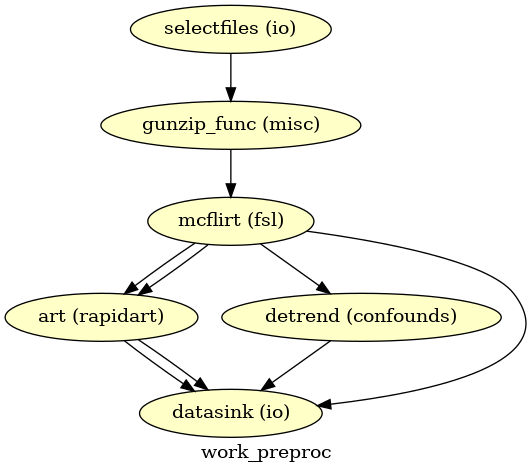

In [19]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='./output5/work_preproc/graph.png', width=300)

In [20]:
preproc.run('MultiProc', plugin_args={'n_procs': 8})

220303-08:24:07,640 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
220303-08:24:07,650 nipype.workflow INFO:
	 Running in parallel.
220303-08:24:07,653 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 452.30/452.30, Free processors: 8/8.
220303-08:24:07,745 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/share/home/connectome/stellasybae/rsfMRIQC/output5/work_preproc/selectfiles".
220303-08:24:07,753 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
220303-08:24:07,758 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001562s.
220303-08:24:09,657 nipype.workflow INFO:
	 [Job 0] Completed (work_preproc.selectfiles).
220303-08:24:09,663 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 452.30/452.30, Free processors: 8/8.
220303-08:24:09,769 nipype.workflow INFO:
	 [Nod

/opt/miniconda-latest/lib/python3.9/site-packages/nipype/algorithms/rapidart.py:514: RuntimeWarning: Mean of empty slice
  g[t0] = np.nanmean(vol[mask])


220303-08:29:41,826 nipype.interface INFO:
	 not intersect_mask is True
220303-08:30:06,357 nipype.workflow INFO:
	 [Node] Finished "art", elapsed time 38.270169s.
220303-08:30:08,17 nipype.workflow INFO:
	 [Job 3] Completed (work_preproc.art).
220303-08:30:08,22 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 452.10/452.30, Free processors: 7/8.
                     Currently running:
                       * work_preproc.detrend
220303-08:30:40,107 nipype.workflow INFO:
	 [Node] Finished "detrend", elapsed time 72.016644s.
220303-08:30:42,50 nipype.workflow INFO:
	 [Job 4] Completed (work_preproc.detrend).
220303-08:30:42,54 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 452.30/452.30, Free processors: 8/8.
220303-08:30:42,140 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.datasink" in "/share/home/connectome/stellasybae/rsfMRIQC/output5/work_preproc/datasink".
220303-08:30:42,153 nipype.workf

# 03 detrend 하면 어떤 일이 발생하는가?

In [23]:
detrended_image = nib.load('/share/home/connectome/stellasybae/rsfMRIQC/output5/work_preproc/detrend/detrend.nii.gz')

In [24]:
detrended_image.shape

(99, 117, 95, 373)

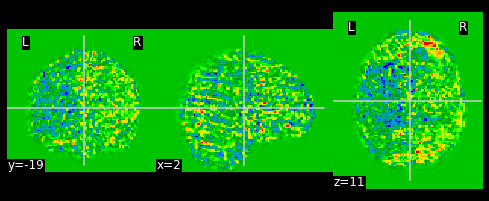

In [25]:
plotting.plot_epi(detrended_image.slicer[:, :, :, 370])#마스크 먹임

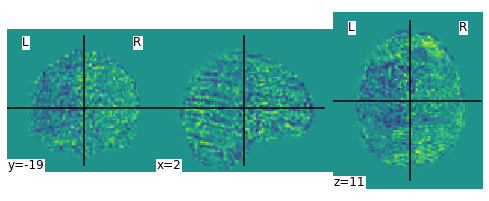

In [26]:
plotting.plot_img(detrended_image.slicer[:, :, :, 370]) #random timepoint

In [ ]:
z_sequence_nilearn = stats.zscore(detrended_image.get_fdata(), axis=0)
ans=0
for i in range(99):
    for j in range(117):
        for k in range(95):
            for l in range(373):
                if z_sequence_nilearn[i][j][k][l] > 5 or z_sequence_nilearn[i][j][k][l] < -5:
                    ans+=1

In [30]:
ans #outliers!

437470

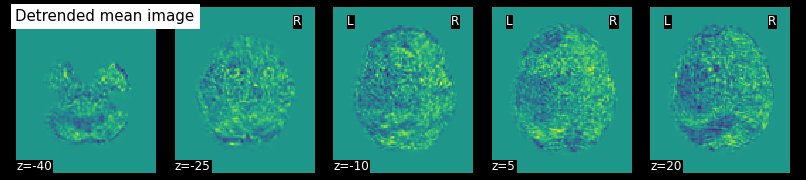

In [44]:
plotting.plot_epi(detrended_image.slicer[:, :, :, 370], title='Detrended mean image', display_mode='z',
         cut_coords=range(-40, 21, 15), cmap=plt.cm.viridis);

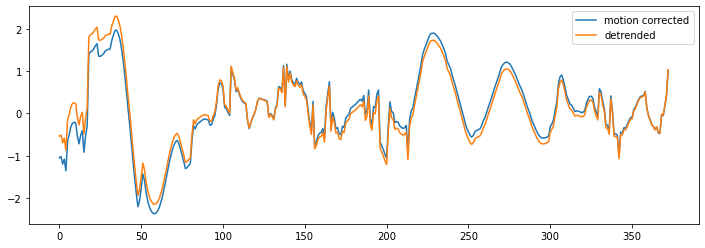

In [48]:
import nibabel as nb
%matplotlib inline
output = './output5/work_preproc/'

# Load the relevant datasets
mc = nb.load(output + 'mcflirt/cleaned_image_sub-NDARINV73D1F1AM_HarvardOxford_mcf.nii.gz')
detrended_data = nb.load(output + 'detrend/detrend.nii.gz')

# Plot a representative voxel
x, y, z = 32, 34, 43
fig = plt.figure(figsize=(12, 4))
plt.plot(mc.get_fdata()[x, y, z, :])
plt.plot(detrended_data.get_fdata()[x, y, z, :])
plt.legend(['motion corrected','detrended']);

# 04 outliers

In [42]:
# Showing the artifact detection output
from IPython.display import SVG
SVG(filename='./output5/work_preproc/art/'
    'plot.cleaned_image_sub-NDARINV73D1F1AM_HarvardOxford_mcf.svg')
outliers = np.loadtxt('./output5/work_preproc/art/'
                      'art.cleaned_image_sub-NDARINV73D1F1AM_HarvardOxford_mcf_outliers.txt')
list(outliers.astype('int'))

[5,
 13,
 14,
 15,
 18,
 83,
 101,
 105,
 108,
 109,
 110,
 115,
 118,
 120,
 128,
 129,
 130,
 131,
 132,
 134,
 137,
 138,
 139,
 140,
 152,
 153,
 154,
 155,
 156,
 166,
 167,
 169,
 170,
 171,
 173,
 175,
 184,
 186,
 188,
 189,
 190,
 191,
 192,
 194,
 195,
 196,
 201,
 202,
 213,
 214,
 254,
 330,
 334,
 337,
 338,
 339,
 342,
 343,
 348,
 350,
 351,
 352,
 358,
 359,
 360,
 366,
 368,
 372]